In [1]:
import sys
path = '/gpfs/commons/groups/gursoy_lab/mstoll/'
sys.path.append(path)

import pandas as pd
import numpy as np
import torch
from functools import partial
import os
import pickle
import time
import copy

from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import LambdaLR, LinearLR, SequentialLR
from torch.utils.tensorboard import SummaryWriter

from codes.models.data_form.DataSets import TabDictDataset
from codes.models.data_form.DataForm import DataTransfo_1SNP
from codes.models.Transformers.Embedding import EmbeddingPheno
from codes.models.Transformers.dic_model_versions import DIC_MODEL_VERSIONS
from codes.models.utils import clear_last_line, print_file, number_tests, Unbuffered, plot_infos, plot_ini_infos


2024-02-22 17:00:31.618214: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 17:00:31.618286: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-22 17:00:31.620151: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-22 17:00:47.072206: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import sys
path = '/gpfs/commons/groups/gursoy_lab/mstoll/'
sys.path.append(path)

import pandas as pd
import numpy as np
import torch
from functools import partial
import os
import pickle
import time
import copy
import shutil
import subprocess

from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import LambdaLR, LinearLR, SequentialLR
from torch.utils.tensorboard import SummaryWriter
from sklearn.utils.class_weight import compute_sample_weight
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

from codes.models.data_form.DataForm import DataTransfo_1SNP, PatientList, Patient
from codes.models.Transformers.Embedding import EmbeddingPheno, EmbeddingPhenoCat
from codes.models.Transformers.dic_model_versions import DIC_MODEL_VERSIONS
from codes.models.utils import clear_last_line, print_file, number_tests, Unbuffered, plot_infos, plot_ini_infos
from codes.models.metrics import calculate_roc_auc
from codes.models.Naive.Naive_model import NaiveModelWeights, CustomDatasetWithLabels
from codes.models.Transformers.FT_Transformer import TabTransformerGeneModel_V2


class TrainModel():
    def __init__(self, model_type=None, model_version=None, test_name=None, pheno_method=None, tryout=None, binary_classes=None, counts_method=None, CHR=None, SNP=None, rollup_depth=None, padding_token=None, prop_train_test=None, load_data=None,\
                save_data=None, remove_none=None, compute_features=None, padding=None, batch_size=None, data_share=None, seuil_diseases=None, equalize_label=None, embedding_method=None, freeze_embedding=None, \
                Embedding_size=None, n_head=None, n_layer=None, Head_size=None, eval_epochs_interval=None, eval_batch_interval=None, p_dropout=None, masking_padding=None, \
                loss_version=None, gamma=None, alpha=None, total_epochs=None, learning_rate_max=None, \
                learning_rate_ini=None, learning_rate_final=None,\
                warm_up_frac=None, from_test=False, decorelate=False, threshold_corr=1, threshold_rare=0, remove_rare=None, list_env_features=[],
                proj_embed=True, instance_size=None, indices=None, list_pheno_ids=None, L1=False, ld='no'): 
        self.model_type = model_type
        self.model_version = model_version
        self.test_name = test_name
        self.pheno_method = pheno_method # Paul, Abby
        self.tryout = tryout # True if we are doing a tryout, False otherwise 
        ### data constants:
        self.CHR = CHR
        self.SNP = SNP
        self.rollup_depth = rollup_depth
        self.binary_classes = binary_classes #nb of classes related to an SNP (here 0 or 1)
        self.ld = ld
        self.padding_token = padding_token
        self.prop_train_test = prop_train_test
        self.load_data = load_data
        self.save_data = save_data
        self.remove_none = remove_none
        self.compute_features = compute_features
        self.padding = padding
        ### data format
        self.batch_size = batch_size
        self.data_share = data_share #402555
        self.seuil_diseases = seuil_diseases
        self.equalize_label = equalize_label
        self.decorelate = decorelate
        self.threshold_corr = threshold_corr
        self.threshold_rare = threshold_rare
        self.remove_rare = remove_rare
        ##### model constants
        self.embedding_method = embedding_method #None, Paul, Abby
        self.counts_method = counts_method
        self.freeze_embedding = freeze_embedding
        self.Embedding_size = Embedding_size # Size of embedding.
        self.proj_embed = proj_embed
        self.instance_size = instance_size
        self.n_head = n_head # number of SA heads
        self.n_layer = n_layer # number of blocks in parallel
        self.Head_size = Head_size  # size of the "single Attention head", which is the sum of the size of all multi Attention heads
        self.eval_epochs_interval = eval_epochs_interval # number of epoch between each evaluation print of the model (no impact on results)
        self.eval_batch_interval = eval_batch_interval
        self.p_dropout = p_dropout # proba of dropouts in the model
        self.masking_padding = masking_padding # do we include padding masking or not
        self.loss_version = loss_version #cross_entropy or focal_loss
        self.gamma = gamma
        self.alpha = alpha
        self.L1 = L1
        ##### training constants
        self.total_epochs = total_epochs # number of epochs
        self.learning_rate_max = learning_rate_max # maximum learning rate (at the end of the warmup phase)
        self.learning_rate_ini = learning_rate_ini # initial learning rate 
        self.learning_rate_final = learning_rate_final
        self.warm_up_frac = warm_up_frac # fraction of the size of the warmup stage with regards to the total number of epochs.
        self.start_factor_lr = learning_rate_ini / learning_rate_max
        self.end_factor_lr = learning_rate_final / learning_rate_max
        self.warm_up_size = int(total_epochs*warm_up_frac)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.number_test = None
        self.number_test = self.get_number_test()
        print(self.tryout)
        self.trained = False
        # to be defined with data
        self.vocab_size = None 
        self.max_count_same_disease = None
        #### essential components of a model
        self.dataT = None
        self.patient_list = None
        self.model = None
        self.number_test_trained = None
        self.list_env_features = list_env_features
        self.indices=indices
        self.list_pheno_ids = list_pheno_ids

       
    @property
    def get_test_name_with_infos(self):
        return str(self.number_test) + '_' + self.test_name + 'tryout'*self.tryout
    def get_number_test(self, update=False):
        if self.number_test != None and update==False:
            return self.number_test
        else:
            df_list_instance_test_saved_path = '/gpfs/commons/datasets/controlled/ukbb-gursoylab/mstoll/list_models_class/list_instance_tests_saved.csv'
            df_list_instance_test_saved = pd.read_csv(df_list_instance_test_saved_path)
            if len(df_list_instance_test_saved.index)==0:
                    self.number_test = 1
            else:
                    number_test_ex =  np.max(df_list_instance_test_saved['number_test'])
                    self.number_test = int(number_test_ex + 1)
            
            return self.number_test
    
    def get_dataT(self):
        
        if self.dataT != None:
            pass        
        else:
            print('Bulding dataT')
            dataT = DataTransfo_1SNP(SNP=self.SNP,
                         CHR=self.CHR,
                         method=self.pheno_method,
                         padding=self.padding,  
                         binary_classes=self.binary_classes,
                         pad_token=self.padding_token, 
                         load_data=self.load_data, 
                         save_data=self.save_data, 
                         compute_features=self.compute_features,
                         data_share=self.data_share,
                         prop_train_test=self.prop_train_test,
                         remove_none=self.remove_none,
                         rollup_depth=self.rollup_depth,
                         equalize_label=self.equalize_label,
                         seuil_diseases=self.seuil_diseases,
                         decorelate=self.decorelate,
                         threshold_corr=self.threshold_corr,
                         threshold_rare=self.threshold_rare,
                         remove_rare=self.remove_rare,
                         list_env_features=self.list_env_features, 
                         indices=self.indices,
                         list_pheno_ids=self.list_pheno_ids,
                         ld=self.ld)
            self.dataT = dataT
            print(f'got dataT')
        return self.dataT
        
    def get_patient_list(self):
        if self.patient_list == None:
            self.patient_list = self.get_dataT().get_patientlist()
        return self.patient_list
    
    def get_model(self):
        Embedding  = EmbeddingPheno(method=self.embedding_method, 
                            counts_method=self.counts_method,
                            vocab_size=self.vocab_size, 
                            max_count_same_disease=self.max_count_same_disease, 
                            Embedding_size=self.Embedding_size, 
                            rollup_depth=self.rollup_depth, 
                            freeze_embed=self.freeze_embedding,
                            dicts=self.dataT.dicts)
        self.Embedding = Embedding
        ### creation of the model
        ClassModel = DIC_MODEL_VERSIONS[self.model_version]
        model = ClassModel(pheno_method = self.pheno_method,
                                    Embedding = Embedding,
                                    Head_size=self.Head_size,
                                    binary_classes=self.binary_classes,
                                    n_head=self.n_head,
                                    n_layer=self.n_layer,
                                    mask_padding=self.masking_padding, 
                                    padding_token=0, 
                                    p_dropout=self.p_dropout, 
                                    loss_version = self.loss_version, 
                                    gamma = self.gamma,
                                    alpha = self.alpha,
                                    device = self.device,
                                    proj_embed=self.proj_embed,
                                    instance_size=self.instance_size,
                                    L1=self.L1)
      
        # print the number of parameters in the model
        print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')
        self.model = model
        return model

    def generate_dirs(self, makedirs=True):

        if self.model_type == 'transformer' or self.model_type == 'naive_model' or self.model_type == 'tab_transformer':
            path = '/gpfs/commons/datasets/controlled/ukbb-gursoylab/mstoll/'

            #check test name
            model_dir = path + f'logs/runs/SNPS/{str(self.CHR)}/{self.SNP}/{self.model_type}/{self.model_version}/{self.pheno_method}'
            model_plot_dir = path + f'logs/plots/tests/SNP/{str(self.CHR)}/{self.SNP}/{self.model_type}/{self.model_version}/{self.pheno_method}/'

            if makedirs:
                os.makedirs(model_dir, exist_ok=True)
                os.makedirs(model_plot_dir, exist_ok=True)
            #check number tests
            test_dir = f'{model_dir}/{self.get_test_name_with_infos}/'
            print(test_dir)
            log_data_dir = f'{test_dir}/data/'
            log_tensorboard_dir = f'{test_dir}/tensorboard/'
            log_slurm_outputs_dir = f'{test_dir}/Slurm/Outputs/'
            log_slurm_errors_dir = f'{test_dir}/Slurm/Errors/'
            if makedirs:
                os.makedirs(log_data_dir, exist_ok=True)
                os.makedirs(log_tensorboard_dir, exist_ok=True)
                os.makedirs(log_slurm_outputs_dir, exist_ok=True)
                os.makedirs(log_slurm_errors_dir, exist_ok=True)


            log_data_path_pickle = f'{test_dir}/data/{self.test_name}.pkl'
            log_tensorboard_path = f'{test_dir}/tensorboard/{self.test_name}'
            log_slurm_outputs_path = f'{test_dir}/Slurm/Outputs/{self.test_name}.txt'
            log_slurm_error_path = f'{test_dir}/Slurm/Errors/{self.test_name}.txt'
            model_plot_path = path + f'logs/plots/tests/SNP/{str(self.CHR)}/{self.SNP}/{self.model_type}/{self.model_version}/{self.pheno_method}/{self.get_test_name_with_infos}.png'

            return log_data_path_pickle, log_tensorboard_path, log_slurm_outputs_path, log_slurm_error_path, model_plot_path
        elif self.model_type == 'logistic_regression':
            path = '/gpfs/commons/groups/gursoy_lab/mstoll/codes/'

            #check test name
            model_dir = path + f'logs/runs/SNPS/{str(self.CHR)}/{self.SNP}/{self.model_type}/{self.model_version}/{self.pheno_method}'
            model_plot_dir = path + f'logs/plots/tests/SNP/{str(self.CHR)}/{self.SNP}/{self.model_type}/{self.model_version}/{self.pheno_method}/'

            if makedirs:
                os.makedirs(model_dir, exist_ok=True)
                os.makedirs(model_plot_dir, exist_ok=True)
            #check number tests
            test_dir = f'{model_dir}/{self.get_test_name_with_infos}/'
            print(test_dir)
            log_data_dir = f'{test_dir}/data/'
            log_res_dir = f'{test_dir}/res/'
            log_slurm_outputs_dir = f'{test_dir}/Slurm/Outputs/'
            log_slurm_errors_dir = f'{test_dir}/Slurm/Errors/'
            if makedirs:
                os.makedirs(log_data_dir, exist_ok=True)
                os.makedirs(log_res_dir, exist_ok=True)
                os.makedirs(log_slurm_outputs_dir, exist_ok=True)
                os.makedirs(log_slurm_errors_dir, exist_ok=True)


            log_data_path_pickle = f'{test_dir}/data/{self.test_name}.pkl'
            log_res_path_txt = f'{test_dir}/res/{self.test_name}.txt'
            log_res_path_pkl = f'{test_dir}/res/{self.test_name}.pkl'

            log_slurm_outputs_path = f'{test_dir}/Slurm/Outputs/{self.test_name}.txt'
            log_slurm_error_path = f'{test_dir}/Slurm/Errors/{self.test_name}.txt'

            return log_data_path_pickle, log_res_path_txt, log_res_path_pkl, log_slurm_outputs_path, log_slurm_error_path

    def to_csv(self):
        dic_attrib = self.__dict__.copy()
        keys_to_drop = ['dataT', 'patient_list', 'model', 'patient_list_transformer_train', 'patient_list_transformer_test', 'dic_data', 'dic_data_train', 'dic_data_test']
        for key in keys_to_drop:
            if key in list(dic_attrib.keys()):
                dic_attrib.pop(key)
        attributes = list(dic_attrib.keys())
        values = list(dic_attrib.values())
        df_row_test = pd.DataFrame([values],columns=attributes)
        return df_row_test
    
    def add_to_trained(self):
        df_row_test = self.to_csv()
        df_list_instance_test_trained_path = '/gpfs/commons/groups/gursoy_lab/mstoll/codes/tests/instance_tests/list_instance_tests_train.csv'
        df_list_instance_test_trained = pd.read_csv(df_list_instance_test_trained_path)
        df_instance_test_row = self.to_csv()
        df_list_instance_test_trained =  pd.concat([df_list_instance_test_trained, df_instance_test_row], ignore_index=True)
        df_list_instance_test_trained.to_csv(df_list_instance_test_trained_path, index=False)
    def add_to_saved(self):
        df_row_test = self.to_csv()
        df_list_instance_test_saved_path = '/gpfs/commons/datasets/controlled/ukbb-gursoylab/mstoll/list_models_class/list_instance_tests_saved.csv'
        df_list_instance_test_saved = pd.read_csv(df_list_instance_test_saved_path)
        df_instance_test_row = self.to_csv()
        df_list_instance_test_saved =  pd.concat([df_list_instance_test_saved, df_instance_test_row], ignore_index=True)
        df_list_instance_test_saved.to_csv(df_list_instance_test_saved_path, index=False)

    def is_equal(self, test):
        pass
            
    def save_model(self, update=False):
        
       
        already_saved, number_test = self.test_already_saved()
        if already_saved and not update:
            self.number_test = number_test
            print('test has already been saved')

        else:
            if not update:
                self.get_number_test(update=True)
            path_instance_test_save_dir= '/gpfs/commons/datasets/controlled/ukbb-gursoylab/mstoll/list_models_class/' 
            path_instance_test_save = f'{path_instance_test_save_dir}{self.get_test_name_with_infos}.pkl'
            with open(path_instance_test_save, 'wb') as file:
                pickle.dump(self, file)
            if update:
                TrainModel.remove_instance_test_df(self.number_test)
            self.add_to_saved()

    def test_already_trained(self):
        
            df_instance_tests_path = '/gpfs/commons/groups/gursoy_lab/mstoll/codes/tests/instance_tests/list_instance_tests_train.csv'
            df_instance_tests = pd.read_csv(df_instance_tests_path)
            df_instance_tests_dropped = df_instance_tests.copy()
            df_test = self.to_csv()

            cols_drop_check_train = ['test_name', 'number_test', 'trained', 'vocab_size', 'max_count_same_disease', 'test_name_with_infos', 'device', 'number_test_trained']
            for col in cols_drop_check_train:
                if col in df_instance_tests_dropped.columns:
                    df_instance_tests_dropped = df_instance_tests_dropped.drop(col, axis=1)
                if col in df_test.columns:
                    df_test = df_test.drop(col, axis=1)
            already_trained = False
            already_trained_index = list(df_instance_tests['number_test'][df_instance_tests_dropped.apply(lambda row: row.equals(df_test.iloc[0]), axis=1)])
            if already_trained_index == []:
                already_trained =False
                number_test = 0
            else:

                already_trained = True
                number_test = already_trained_index[0]
                self.number_test_trained = number_test
            self.save_model(update=True)
            return already_trained, number_test  

    def test_already_saved(self):
        
        df_instance_tests_path = '/gpfs/commons/datasets/controlled/ukbb-gursoylab/mstoll/list_models_class/list_instance_tests_saved.csv'
        df_instance_tests = pd.read_csv(df_instance_tests_path)
        df_instance_tests_dropped = df_instance_tests.copy()

        df_test = self.to_csv()
        cols_drop_check_train = ['number_test', 'trained', 'vocab_size', 'max_count_same_disease', 'test_name_with_infos', 'device', 'number_test_trained']
        for col in cols_drop_check_train:
            if col in df_instance_tests_dropped.columns:
                df_instance_tests_dropped = df_instance_tests_dropped.drop(col, axis=1)
            if col in df_test.columns:
                df_test = df_test.drop(col, axis=1)
        already_saved = False
        already_saved_index = list(df_instance_tests['number_test'][df_instance_tests_dropped.apply(lambda row: row.equals(df_test.iloc[0]), axis=1)])
        if already_saved_index == []:
            already_saved =False
            number_test = 0
        else:
            already_saved = True
            number_test = already_saved_index[0]
        return already_saved, number_test    
    
    @staticmethod
    def load_instance_test(instance_test_number):
        instance_model_dir = '/gpfs/commons/datasets/controlled/ukbb-gursoylab/mstoll/list_models_class/'
        for instance_test in os.listdir(instance_model_dir):
            if instance_test == 'list_instance_tests_saved.csv':
                pass
            else:
                number_instance_test_try = int(instance_test.split('_')[0])
            
                if number_instance_test_try == instance_test_number:
                    with open(f'{instance_model_dir}{instance_test}', 'rb') as file:
                        test_instance = pickle.load(file)
                        return test_instance
        print('test was not found')

    @staticmethod
    def remove_instance_test(instance_test_number):
        instance_model_dir = '/gpfs/commons/datasets/controlled/ukbb-gursoylab/mstoll/list_models_class/'
        for instance_test in os.listdir(instance_model_dir):
            if instance_test == 'list_instance_tests_saved.csv':
                pass
            else:
                number_instance_test_try = int(instance_test.split('_')[0])
            
                if number_instance_test_try == instance_test_number:
                    os.remove(f'{instance_model_dir}{instance_test}')
        TrainModel.remove_instance_test_df(instance_test_number)

    @staticmethod
    def remove_instance_test_df(instance_test_number):
        df_list_instance_test_saved_path = '/gpfs/commons/datasets/controlled/ukbb-gursoylab/mstoll/list_models_class/list_instance_tests_saved.csv'
        df_list_instance_test_saved = pd.read_csv(df_list_instance_test_saved_path)
        df_list_instance_test_saved = df_list_instance_test_saved[ df_list_instance_test_saved['number_test'] != instance_test_number]
        df_list_instance_test_saved.to_csv(df_list_instance_test_saved_path, index=False)


    @staticmethod
    def get_res_instance_test(instance_test_number=None, instance_test=None, actual_test=False,add=True):
        if instance_test == None:
            instance_test = TrainModel.load_instance_test(instance_test_number)
        path_tensorboard_test_instance = f'/gpfs/commons/datasets/controlled/ukbb-gursoylab/mstoll/logs/tensorboard/tests/all_instances/SNPS/{str(instance_test.CHR)}/{instance_test.SNP}/{instance_test.model_type}/{instance_test.model_version}/{instance_test.pheno_method}/{instance_test.get_test_name_with_infos}'
        if instance_test.number_test_trained != None:
            instance_test_trained = TrainModel.load_instance_test(instance_test_number=instance_test.number_test_trained)
            log_data_path_pickle, log_tensorboard_path, log_slurm_outputs_path, log_slurm_error_path  = instance_test_trained.generate_dirs()
        else:
            log_data_path_pickle, log_tensorboard_path, log_slurm_outputs_path, log_slurm_error_path, plots_path  = instance_test.generate_dirs()

        if os.path.exists(path_tensorboard_test_instance): 
            shutil.rmtree(path_tensorboard_test_instance)

        shutil.copytree(log_tensorboard_path, path_tensorboard_test_instance )
        if actual_test:
            if add==False:
                shutil.rmtree(f'/gpfs/commons/datasets/controlled/ukbb-gursoylab/mstoll/logs/tensorboard/actual_test/')
            os.makedirs(f'/gpfs/commons/datasets/controlled/ukbb-gursoylab/mstoll/logs/tensorboard/actual_test/', exist_ok=True)
            actual_test_dir = f'/gpfs/commons/datasets/controlled/ukbb-gursoylab/mstoll/logs/tensorboard/actual_test/{instance_test.get_test_name_with_infos}'
            if os.path.exists(actual_test_dir): 
                shutil.rmtree(actual_test_dir)

            shutil.copytree(path_tensorboard_test_instance, actual_test_dir)

class TrainTransformerModel(TrainModel):
    def __init__(self, model_version, test_name, pheno_method, tryout, CHR, SNP, rollup_depth, binary_classes,counts_method, padding_token, prop_train_test, load_data,
                save_data, remove_none, compute_features, padding, batch_size, data_share, seuil_diseases, equalize_label, embedding_method, freeze_embedding, Embedding_size, n_head, 
                 n_layer, Head_size, eval_epochs_interval, eval_batch_interval, p_dropout, masking_padding, loss_version, gamma, alpha, total_epochs, learning_rate_max, learning_rate_ini, learning_rate_final,
                    warm_up_frac, decorelate, threshold_corr, threshold_rare, remove_rare, list_env_features, proj_embed, instance_size, indices=None, list_pheno_ids=None, L1=False, ld='no'):
        self.model_type = 'transformer'
        super().__init__(model_type=self.model_type, model_version=model_version, test_name=test_name, pheno_method=pheno_method, tryout=tryout, 
                        CHR=CHR, SNP=SNP, rollup_depth=rollup_depth, binary_classes=binary_classes, counts_method=counts_method, padding_token=padding_token, prop_train_test=prop_train_test,
                        load_data=load_data,save_data=save_data, remove_none=remove_none, compute_features=compute_features, padding=padding, batch_size=batch_size,
                        data_share=data_share, seuil_diseases=seuil_diseases, equalize_label=equalize_label, embedding_method=embedding_method, 
                        freeze_embedding=freeze_embedding, Embedding_size=Embedding_size, n_head=n_head, n_layer=n_layer, Head_size=Head_size,
                        eval_epochs_interval=eval_epochs_interval, eval_batch_interval=eval_batch_interval, p_dropout=p_dropout, masking_padding=masking_padding,
                        loss_version=loss_version, gamma=gamma, alpha=alpha, total_epochs=total_epochs, learning_rate_max=learning_rate_max, learning_rate_ini=learning_rate_ini,
                        learning_rate_final=learning_rate_final,warm_up_frac=warm_up_frac, decorelate=decorelate, threshold_corr=threshold_corr, threshold_rare=threshold_rare, remove_rare=remove_rare, list_env_features=list_env_features,
                        proj_embed=proj_embed, instance_size=instance_size, indices=indices, list_pheno_ids=list_pheno_ids, L1=L1, ld=ld)
        
    

    def train_model(self):
        self.get_number_test() #update the test number
        already_trained, number_test = self.test_already_trained()
        
        log_data_path_pickle, log_tensorboard_path, log_slurm_outputs_path, log_slurm_error_path, plots_path = self.generate_dirs(makedirs = True)
        # Redirect  output to a file
        sys.stdout = open(log_slurm_outputs_path, 'w')
        sys.stderr = open(log_slurm_error_path, 'w')
        sys.stdout = Unbuffered(sys.stdout)
        sys.stderr = Unbuffered(sys.stderr)
        if already_trained:
            print('model has already been trained')
           
        else: 
            print(f'Begining of training program, device={self.device}')
            self.get_dataT()
            self.get_patient_list()
            


            indices_train, indices_test = self.dataT.get_indices_train_test(nb_data=len(self.patient_list),prop_train_test=self.prop_train_test)
            self.patient_list_transformer_train, self.patient_list_transformer_test = self.patient_list.get_transformer_data(indices_train.astype(int), indices_test.astype(int))
            #creation of torch Datasets:
            dataloader_train = DataLoader(self.patient_list_transformer_train, batch_size=self.batch_size, shuffle=True)
            dataloader_test = DataLoader(self.patient_list_transformer_test, batch_size=self.batch_size, shuffle=True)


            if self.patient_list.nb_distinct_diseases_tot==None:
                vocab_size = self.patient_list.get_nb_distinct_diseases_tot()
            if self.patient_list.nb_max_counts_same_disease==None:
                max_count_same_disease = self.patient_list.get_max_count_same_disease()
            self.max_count_same_disease = self.patient_list.nb_max_counts_same_disease
            self.vocab_size = self.patient_list.get_nb_distinct_diseases_tot()

            print(f'\n vocab_size : {self.vocab_size}, max_count : {self.max_count_same_disease}\n', 
                f'length_patient = {self.patient_list.get_nb_max_distinct_diseases_patient()}\n',
                f'sparcity = {self.patient_list.sparsity}\n',
                f'nombres patients  = {len(self.patient_list)}')
            
            writer = SummaryWriter(log_tensorboard_path)

            self.get_model()


                                
            self.model.to(self.device)
            # print the number of parameters in the model
            print(sum(p.numel() for p in self.model.parameters())/1e6, 'M parameters')


            optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.learning_rate_max)
            lr_scheduler_warm_up = LinearLR(optimizer, start_factor=self.start_factor_lr , end_factor=1, total_iters=self.warm_up_size, verbose=False) # to schedule a modification in the learning rate
            lr_scheduler_final = LinearLR(optimizer, start_factor=1, total_iters=self.total_epochs-self.warm_up_size, end_factor=self.end_factor_lr)
            lr_scheduler = SequentialLR(optimizer, schedulers=[lr_scheduler_warm_up, lr_scheduler_final], milestones=[self.warm_up_size])


            output_file = log_slurm_outputs_path
            ## Open tensor board writer
            dic_features_list = {
            'list_training_loss' : [],
            'list_validation_loss' : [],
            'list_proba_avg_zero' : [],
            'list_proba_avg_one' : [],
            'list_auc_validation' : [],
            'list_accuracy_validation' : [],
            'list_f1_validation' : [],
            'epochs' : [] }

            # Training Loop
            start_time_training = time.time()
            print_file(output_file, f'Beginning of the program for {self.total_epochs} epochs', new_line=True)
            # Training Loop
            plot_ini_infos(self.model, output_file, dataloader_test, dataloader_train, writer, dic_features_list)
            for epoch in range(1, self.total_epochs+1):

                start_time_epoch = time.time()
                total_loss = 0.0  
                
                #with tqdm(total=len(dataloader_train), position=0, leave=True) as pbar:
                for k, (batch_sentences, batch_counts, batch_labels) in enumerate(dataloader_train):
                    
                    batch_sentences = batch_sentences.to(self.device)
                    batch_counts = batch_counts.to(self.device)
                    batch_labels = batch_labels.to(self.device)

                    # evaluate the loss
                    logits, loss = self.model(batch_sentences, batch_counts, batch_labels)
                    optimizer.zero_grad(set_to_none=True)
                    loss.backward()
                

                    total_loss += loss.item()

                    optimizer.step()

                    if k % self.eval_batch_interval == 0:
                        clear_last_line(output_file)
                        print_file(output_file, f'Progress in epoch {epoch}  = {round(k / len(dataloader_train)*100, 2)} %, time batch : {time.time() - start_time_epoch}', new_line=False)

                if epoch % self.eval_epochs_interval == 0:
                    dic_features = plot_infos(self.model, output_file, epoch, total_loss, start_time_epoch, dataloader_train, dataloader_test, optimizer, writer, dic_features_list, plots_path)

                
                
                lr_scheduler.step()

            self.dic_features = dic_features
            if self.model.padding_mask != None:
                self.model.padding_mask = self.model.padding_mask.to('cpu')
                self.model.padding_mask_probas = self.model.padding_mask_probas.to('cpu')

            self.model.to('cpu')
            self.Embedding.to('cpu')
            self.model.write_embedding(writer)
            # Print time
            print_file(output_file, f"Training finished: {int(time.time() - start_time_training)} seconds", new_line=True)
            start_time = time.time()

            with open(log_data_path_pickle, 'wb') as file:
                pickle.dump(self, file)
            print('Model saved to %s' % log_data_path_pickle)

            

            
            ## Add hyper parameters to tensorboard
            hyperparams = {"CHR" : self.CHR, "SNP" : self.SNP, "ROLLUP LEVEL" : self.rollup_depth,
                        'PHENO_METHOD': self.pheno_method, 'EMBEDDING_METHOD': self.embedding_method,
                        'EMBEDDING SIZE' : self.Embedding_size, 'ATTENTION HEADS' : self.n_head, 'BLOCKS' : self.n_layer,
                        'LR':1 , 'DROPOUT' : self.p_dropout, 'NUM_EPOCHS' : self.total_epochs, 
                        'BATCH_SIZE' : self.batch_size, 
                        'PADDING_MASKING': self.masking_padding,
                        'VERSION' : self.model_version,
                        'NB_Patients'  : len(self.patient_list),
                        'LOSS_VERSION'  : self.loss_version,
                        }
            writer.add_hparams(hyperparams, dic_features)

            self.trained = True

            self.save_model(update=True)
            self.add_to_trained()

class TrainTabTransformerModel(TrainModel):
    def __init__(self, model_version, test_name, pheno_method, tryout, CHR, SNP, rollup_depth, binary_classes, counts_method,  padding_token, prop_train_test, load_data,
                save_data, remove_none, compute_features, padding, batch_size, data_share, seuil_diseases, equalize_label, embedding_method, freeze_embedding, Embedding_size, n_head, 
                 n_layer, Head_size, eval_epochs_interval, eval_batch_interval, p_dropout, masking_padding, loss_version, gamma, alpha, total_epochs, learning_rate_max, learning_rate_ini, learning_rate_final,
                    warm_up_frac, decorelate, threshold_corr, threshold_rare, remove_rare, list_env_features, proj_embed, instance_size, indices=None, list_pheno_ids=None, ld='no'):
        self.model_type = 'tab_transformer'
        super().__init__(model_type=self.model_type, model_version=model_version, test_name=test_name, pheno_method=pheno_method, tryout=tryout, 
                        CHR=CHR, SNP=SNP, rollup_depth=rollup_depth, binary_classes=binary_classes, counts_method=counts_method, padding_token=padding_token, prop_train_test=prop_train_test,
                        load_data=load_data,save_data=save_data, remove_none=remove_none, compute_features=compute_features, padding=padding, batch_size=batch_size,
                        data_share=data_share, seuil_diseases=seuil_diseases, equalize_label=equalize_label, embedding_method=embedding_method, 
                        freeze_embedding=freeze_embedding, Embedding_size=Embedding_size, n_head=n_head, n_layer=n_layer, Head_size=Head_size,
                        eval_epochs_interval=eval_epochs_interval, eval_batch_interval=eval_batch_interval, p_dropout=p_dropout, masking_padding=masking_padding,
                        loss_version=loss_version, gamma=gamma, alpha=alpha, total_epochs=total_epochs, learning_rate_max=learning_rate_max, learning_rate_ini=learning_rate_ini,
                        learning_rate_final=learning_rate_final,warm_up_frac=warm_up_frac, decorelate=decorelate, threshold_corr=threshold_corr, threshold_rare=threshold_rare, remove_rare=remove_rare, list_env_features=list_env_features,
                        proj_embed=proj_embed, instance_size=instance_size, indices=indices, list_pheno_ids=list_pheno_ids, ld=ld)
        
    
    def get_model(self):
        Embedding  = EmbeddingPhenoCat(method=self.embedding_method, 
                            max_count_same_disease=self.max_count_same_disease, 
                            Embedding_size=self.Embedding_size, 
                            rollup_depth=self.rollup_depth, 
                            freeze_embed=self.freeze_embedding,
                            dic_embedding_cat_params=self.dic_embedding_cat_params,
                            dicts=self.dataT.dicts,
                            device=self.device)
        self.Embedding = Embedding
        ### creation of the model
        model = TabTransformerGeneModel_V2(
                                    pheno_method = self.pheno_method,
                                    Embedding = Embedding,
                                    Head_size=self.Head_size,
                                    Classes_nb=self.Classes_nb,
                                    n_head=self.n_head,
                                    n_layer=self.n_layer,
                                    mask_padding=self.masking_padding, 
                                    padding_token=0, 
                                    p_dropout=self.p_dropout, 
                                    loss_version = self.loss_version, 
                                    gamma = self.gamma,
                                    alpha = self.alpha,
                                    device = self.device,
                                    proj_embed = self.proj_embed
                                          )
        # print the number of parameters in the model
        print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')
        self.model = model
        return model
    
    def train_model(self):
        self.get_number_test() #update the test number
        already_trained, number_test = self.test_already_trained()
        
        log_data_path_pickle, log_tensorboard_path, log_slurm_outputs_path, log_slurm_error_path, plots_path = self.generate_dirs(makedirs = True)
        # Redirect  output to a file
        sys.stdout = open(log_slurm_outputs_path, 'w')
        sys.stderr = open(log_slurm_error_path, 'w')
        sys.stdout = Unbuffered(sys.stdout)
        sys.stderr = Unbuffered(sys.stderr)
        if already_trained:
            print('model has already been trained')
           
        else: 
            print(f'Begining of training program, device={self.device}')
            self.get_dataT()
            self.dic_data= self.dataT.get_data_tabtransfo(actualise_phenos=True)
            indices_train, indices_test = self.dataT.get_indices_train_test(nb_data=len(self.dic_data['diseases']))
            dic_data_train = {key: np.array(self.dic_data[key])[indices_train] for key in self.dic_data.keys()}
            dic_data_test = {key: np.array(self.dic_data[key])[indices_test] for key in self.dic_data.keys()}
            max_number_diseases = self.patient_list.get_nb_distinct_diseases_tot()
            max_number_counts = self.patient_list.get_max_count_same_disease()
            max_number_age = np.max(np.array(self.dataT.dic_list_patients_test['age'])) + 1
            max_number_sex = 2
            self.dic_embedding_cat_params = {'diseases':max_number_diseases, 'counts':max_number_counts, 'age':max_number_age, 'sex':max_number_sex} 

            dataloader_train =  DataLoader(self.Dataset_tab_train, batch_size = self.batch_size, shuffle=True)
            dataloader_test =  DataLoader(self.Dataset_tab_test, batch_size = self.batch_size, shuffle=True)
            
            if self.patient_list.nb_distinct_diseases_tot==None:
                vocab_size = self.patient_list.get_nb_distinct_diseases_tot()
            if self.patient_list.nb_max_counts_same_disease==None:
                max_count_same_disease = self.patient_list.get_max_count_same_disease()
            self.max_count_same_disease = self.patient_list.nb_max_counts_same_disease
            self.vocab_size = self.patient_list.get_nb_distinct_diseases_tot()

            print(f'\n vocab_size : {self.vocab_size}, max_count : {self.max_count_same_disease}\n', 
                f'length_patient = {self.patient_list.get_nb_max_distinct_diseases_patient()}\n',
                f'sparcity = {self.patient_list.sparsity}\n',
                f'nombres patients  = {len(self.patient_list)}')
            
            writer = SummaryWriter(log_tensorboard_path)

            self.get_model()


                                
            self.model.to(self.device)
            # print the number of parameters in the model
            print(sum(p.numel() for p in self.model.parameters())/1e6, 'M parameters')


            optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.learning_rate_max)
            lr_scheduler_warm_up = LinearLR(optimizer, start_factor=self.start_factor_lr , end_factor=1, total_iters=self.warm_up_size, verbose=False) # to schedule a modification in the learning rate
            lr_scheduler_final = LinearLR(optimizer, start_factor=1, total_iters=self.total_epochs-self.warm_up_size, end_factor=self.end_factor_lr)
            lr_scheduler = SequentialLR(optimizer, schedulers=[lr_scheduler_warm_up, lr_scheduler_final], milestones=[self.warm_up_size])


            output_file = log_slurm_outputs_path
            ## Open tensor board writer
            dic_features_list = {
            'list_training_loss' : [],
            'list_validation_loss' : [],
            'list_proba_avg_zero' : [],
            'list_proba_avg_one' : [],
            'list_auc_validation' : [],
            'list_accuracy_validation' : [],
            'list_f1_validation' : [],
            'epochs' : [] }

            # Training Loop
            start_time_training = time.time()
            print_file(output_file, f'Beginning of the program for {self.total_epochs} epochs', new_line=True)
            # Training Loop
            plot_ini_infos(self.model, output_file, self.dataloader_test, self.dataloader_train, writer, dic_features_list)
            for epoch in range(1, self.total_epochs+1):

                start_time_epoch = time.time()
                total_loss = 0.0  
                
                #with tqdm(total=len(dataloader_train), position=0, leave=True) as pbar:
                for k, input_dict in enumerate(dataloader_train):
                    
    

                    # evaluate the loss
                    logits, loss = self.model(input_dict)
                    optimizer.zero_grad(set_to_none=True)
                    loss.backward()
                

                    total_loss += loss.item()

                    optimizer.step()

                    if k % self.eval_batch_interval == 0:
                        clear_last_line(output_file)
                        print_file(output_file, f'Progress in epoch {epoch}  = {round(k / len(dataloader_train)*100, 2)} %, time batch : {time.time() - start_time_epoch}', new_line=False)

                if epoch % self.eval_epochs_interval == 0:
                    dic_features = plot_infos(self.model, output_file, epoch, total_loss, start_time_epoch, dataloader_train, dataloader_test, optimizer, writer, dic_features_list, plots_path)

                
                
                lr_scheduler.step()

            
            self.dic_features = dic_features
            self.model = self.model.to('cpu')
            if self.model.padding_mask != None:
                self.model.padding_mask.to('cpu')
                self.model.padding_mask_probas.to('cpu')

            self.model.write_embedding(writer)
            # Print time
            print_file(output_file, f"Training finished: {int(time.time() - start_time_training)} seconds", new_line=True)
            start_time = time.time()

            with open(log_data_path_pickle, 'wb') as file:
                pickle.dump(self, file)
            print('Model saved to %s' % log_data_path_pickle)

            

            
            ## Add hyper parameters to tensorboard
            hyperparams = {"CHR" : self.CHR, "SNP" : self.SNP, "ROLLUP LEVEL" : self.rollup_depth,
                        'PHENO_METHOD': self.pheno_method, 'EMBEDDING_METHOD': self.embedding_method,
                        'EMBEDDING SIZE' : self.Embedding_size, 'ATTENTION HEADS' : self.n_head, 'BLOCKS' : self.n_layer,
                        'LR':1 , 'DROPOUT' : self.p_dropout, 'NUM_EPOCHS' : self.total_epochs, 
                        'BATCH_SIZE' : self.batch_size, 
                        'PADDING_MASKING': self.masking_padding,
                        'VERSION' : self.model_version,
                        'NB_Patients'  : len(self.patient_list),
                        'LOSS_VERSION'  : self.loss_version,
                        }
            writer.add_hparams(hyperparams, dic_features)

            self.trained = True

            self.save_model(update=True)
            self.add_to_trained()








class TrainLogRegModel(TrainModel):
    def __init__(self, model_version, test_name, pheno_method, tryout, CHR, SNP, rollup_depth, binary_classes, counts_method, padding_token, prop_train_test, load_data,
                save_data, remove_none, compute_features, padding, batch_size, data_share, seuil_diseases, equalize_label, embedding_method, freeze_embedding, Embedding_size, n_head, 
                 n_layer, Head_size, eval_epochs_interval, eval_batch_interval, p_dropout, masking_padding, loss_version, gamma, alpha, total_epochs, learning_rate_max, learning_rate_ini, learning_rate_final,
                    warm_up_frac, decorelate, threshold_corr, threshold_rare, remove_rare, indices=None, list_pheno_ids=None):
        self.model_type = 'logistic_regression'
        super().__init__(model_type=self.model_type, model_version=model_version, test_name=test_name, pheno_method=pheno_method, tryout=tryout, 
                        CHR=CHR, SNP=SNP, rollup_depth=rollup_depth, binary_classes=binary_classes, counts_method=counts_method, padding_token=padding_token, prop_train_test=prop_train_test,
                        load_data=load_data,save_data=save_data, remove_none=remove_none, compute_features=compute_features, padding=padding, batch_size=batch_size,
                        data_share=data_share, seuil_diseases=seuil_diseases, equalize_label=equalize_label, embedding_method=embedding_method, 
                        freeze_embedding=freeze_embedding, Embedding_size=Embedding_size, n_head=n_head, n_layer=n_layer, Head_size=Head_size,
                        eval_epochs_interval=eval_epochs_interval, eval_batch_interval=eval_batch_interval, p_dropout=p_dropout, masking_padding=masking_padding,
                        loss_version=loss_version, gamma=gamma, alpha=alpha, total_epochs=total_epochs, learning_rate_max=learning_rate_max, learning_rate_ini=learning_rate_ini,
                        learning_rate_final=learning_rate_final,warm_up_frac=warm_up_frac, decorelate=decorelate, threshold_corr=threshold_corr, threshold_rare=threshold_rare, remove_rare=remove_rare, indices=indices, list_pheno_ids=list_pheno_ids)
        
    def train_model(self):
        self.get_number_test() #update the test number
        already_trained, number_test = self.test_already_trained()
        
        log_data_path_pickle, log_res_path_txt, log_res_path_pickle, log_slurm_outputs_path, log_slurm_error_path = self.generate_dirs(makedirs = True)
        # Redirect  output to a file
        sys.stdout = open(log_slurm_outputs_path, 'w')
        sys.stderr = open(log_slurm_error_path, 'w')
        sys.stdout = Unbuffered(sys.stdout)
        sys.stderr = Unbuffered(sys.stderr)
        if already_trained:
            print('model has already been trained')
           
        else: 
            print(f'Begining of training program, device={self.device}')
            self.get_dataT()
            self.get_patient_list()

        if self.model_version == 'global':
            indices = np.arange(len(self.patient_list))
            np.random.shuffle(indices)
            pheno_data, label_data = self.patient_list.get_tree_data()
            pheno_data_train = np.array(pheno_data)[indices[:int(self.prop_train_test*len(self.patient_list))]]
            label_data_train = np.array(label_data)[indices[:int(self.prop_train_test*len(self.patient_list))]]
            label_data_test = np.array(label_data)[indices[int(self.prop_train_test*len(self.patient_list)):]]
            pheno_data_test = np.array(pheno_data)[indices[int(self.prop_train_test*len(self.patient_list)):]]                        
            class_weights = compute_sample_weight(class_weight='balanced', y=label_data_train)

            # Adjust the input data with the square root of weights
            sqrt_weights = np.sqrt(class_weights)
            pheno_data_train_weighted = pheno_data_train * sqrt_weights[:, np.newaxis]
            column_one_train = np.ones((pheno_data_train.shape[0],1 ))
            column_one_test = np.ones((pheno_data_test.shape[0],1 ))

            pheno_data_train_weighted_with_constant=  np.concatenate([column_one_train, pheno_data_train_weighted], axis = 1)
            pheno_data_train_with_constant =  np.concatenate([column_one_train, pheno_data_train], axis = 1)
            pheno_data_test_with_constant =  np.concatenate([column_one_test, pheno_data_test], axis = 1)

            logit_model = sm.Logit(label_data_train, pheno_data_train_weighted_with_constant)
            result = logit_model.fit(method='bfgs', disp=True)
            ### visualisation des donnes avec df
            proba_test = result.predict(pheno_data_test_with_constant)
            proba_train = result.predict(pheno_data_train_weighted_with_constant)


            labels_pred_test = (proba_test > 0.5).astype(int)
            nb_positive_test = np.sum(labels_pred_test==0)
            nb_negative_test = np.sum(labels_pred_test==1)
            labels_pred_train = (proba_train > 0.5).astype(int)
            nb_positive_train = np.sum(labels_pred_train==0)
            nb_negative_train = np.sum(labels_pred_train==1)


            TP_test = np.sum((label_data_test==0 )& (labels_pred_test == 0)) / nb_positive_test
            FP_test = np.sum((label_data_test==1 )& (labels_pred_test == 0)) / nb_positive_test
            TN_test = np.sum((label_data_test==1 )& (labels_pred_test == 1)) / nb_negative_test
            FN_test = np.sum((label_data_test== 0)& (labels_pred_test == 1)) / nb_negative_test

            TP_train = np.sum((label_data_train==0 )& (labels_pred_train == 0)) / nb_positive_train
            FP_train = np.sum((label_data_train==1 )& (labels_pred_train == 0)) / nb_positive_train
            TN_train = np.sum((label_data_train==1 )& (labels_pred_train == 1)) / nb_negative_train
            FN_train = np.sum((label_data_train== 0)& (labels_pred_train == 1)) / nb_negative_train


            auc_test = calculate_roc_auc(label_data_test, proba_test)
            auc_train = calculate_roc_auc(label_data_train, proba_train)

            with open(log_res_path_txt, 'w') as file:
                file.write(f'TP_test={TP_test}\n')
                file.write(f'TN_test={TP_test}\n')
                file.write(f'TP_train={TP_train}\n')
                file.write(f'TN_train={TP_train}\n')    
                file.write(f'auc_test={auc_test}\n')        
                file.write(f'auc_train={auc_train}\n')        

            with open(log_data_path_pickle, 'wb') as file:
                pickle.dump(self, file)
                print('Model saved to %s' % log_data_path_pickle)

            dic_res = {'label_test':label_data_test, 'label_train':label_data_train,
                        'label_pred_test':labels_pred_test, 'label_pred_train':labels_pred_train, 
                        'proba_test':proba_test, 'proba_train':proba_train}
            with open(log_res_path_pickle, 'wb') as file:
                pickle.dump(dic_res, file)
                print('Res saved to %s' % log_res_path_pickle)

class TrainNaiveModel(TrainModel):
    def __init__(self, model_version, test_name, pheno_method, tryout, CHR, SNP, rollup_depth, binary_classes, counts_method, padding_token, prop_train_test, load_data,
                save_data, remove_none, compute_features, padding, batch_size, data_share, seuil_diseases, equalize_label, embedding_method, freeze_embedding, Embedding_size, n_head, 
                 n_layer, Head_size, eval_epochs_interval, eval_batch_interval, p_dropout, masking_padding, loss_version, gamma, alpha, total_epochs, learning_rate_max, learning_rate_ini, learning_rate_final,
                    warm_up_frac, decorelate, threshold_corr, threshold_rare, remove_rare, list_env_features, indices=None, list_pheno_ids=None):
        self.model_type = 'naive_model'
        super().__init__(model_type=self.model_type, model_version=model_version, test_name=test_name, pheno_method=pheno_method, tryout=tryout, 
                        CHR=CHR, SNP=SNP, rollup_depth=rollup_depth, binary_classes=binary_classes, counts_method=counts_method, padding_token=padding_token, prop_train_test=prop_train_test,
                        load_data=load_data,save_data=save_data, remove_none=remove_none, compute_features=compute_features, padding=padding, batch_size=batch_size,
                        data_share=data_share, seuil_diseases=seuil_diseases, equalize_label=equalize_label, embedding_method=embedding_method, 
                        freeze_embedding=freeze_embedding, Embedding_size=Embedding_size, n_head=n_head, n_layer=n_layer, Head_size=Head_size,
                        eval_epochs_interval=eval_epochs_interval, eval_batch_interval=eval_batch_interval, p_dropout=p_dropout, masking_padding=masking_padding,
                        loss_version=loss_version, gamma=gamma, alpha=alpha, total_epochs=total_epochs, learning_rate_max=learning_rate_max, learning_rate_ini=learning_rate_ini,
                        learning_rate_final=learning_rate_final,warm_up_frac=warm_up_frac, decorelate=decorelate, threshold_corr=threshold_corr, threshold_rare=threshold_rare, remove_rare=remove_rare, indices=indices, list_pheno_ids=list_pheno_ids)


    def train_model(self):
        self.get_number_test() #update the test number
        already_trained, number_test = self.test_already_trained()

        log_data_path_pickle, log_tensorboard_path, log_slurm_outputs_path, log_slurm_error_path, plots_path = self.generate_dirs(makedirs = True)
        # Redirect  output to a file
        sys.stdout = open(log_slurm_outputs_path, 'w')
        sys.stderr = open(log_slurm_error_path, 'w')
        sys.stdout = Unbuffered(sys.stdout)
        sys.stderr = Unbuffered(sys.stderr)
        if already_trained:
            print('model has already been trained')
            self.save_model()
        else: 
            print(f'Begining of training program, device={self.device}')
            start_time_training = time.time()
            self.get_dataT()
            data, labels, indices_env, name_envs = self.dataT.get_tree_data(with_env=False)
            if self.equalize_label:
                data, labels = DataTransfo_1SNP.equalize_label(data, labels)  
            self.data = data          
            self.nb_phenos = data.shape[1]
            data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size = 1-self.prop_train_test, random_state=42)
            data_train = CustomDatasetWithLabels(data_train, labels)
            dataloader_train = DataLoader(data_train, batch_size=self.batch_size, shuffle=True)
            data_test = CustomDatasetWithLabels(data_test, labels)
            dataloader_test = DataLoader(data_test, batch_size=self.batch_size, shuffle=True)
            self.model = NaiveModelWeights(pheno_nb=self.nb_phenos)
            optimizer = torch.optim.AdamW(self.model.parameters(), lr=0.0001)
            output_file = log_slurm_outputs_path

            writer = SummaryWriter(log_tensorboard_path)
            dic_features_list = {
                'list_training_loss' : [],
                'list_validation_loss' : [],
                'list_proba_avg_zero' : [],
                'list_proba_avg_one' : [],
                'list_auc_validation' : [],
                'list_accuracy_validation' : [],
                'list_f1_validation' : [],
                'epochs' : [] }
            for epoch in range(self.total_epochs):
                start_time_epoch = time.time()
                total_loss = 0
                for k, batch in enumerate(dataloader_train):
                    data_train= batch['data']
                    labels_train = batch['label']
                    # evaluate the loss
                    pred_probas, loss = self.model(data_train, labels_train)
                    optimizer.zero_grad(set_to_none=True)
                    loss.backward()
                    optimizer.step()
                
                if epoch % self.eval_epochs_interval==0:
                    dic_features = plot_infos(self.model, output_file, epoch, total_loss, start_time_epoch, dataloader_train, dataloader_test, optimizer, writer, dic_features_list, plots_path)


                
             # Print time
            print_file(output_file, f"Training finished: {int(time.time() - start_time_training)} seconds", new_line=True)
            start_time = time.time()

            with open(log_data_path_pickle, 'wb') as file:
                pickle.dump(self, file)
            print('Model saved to %s' % log_data_path_pickle)

            




            ## Add hyper parameters to tensorboard
            hyperparams = {"CHR" : self.CHR, "SNP" : self.SNP, "ROLLUP LEVEL" : self.rollup_depth,
                        'PHENO_METHOD': self.pheno_method, 'EMBEDDING_METHOD': self.embedding_method,
                        'EMBEDDING SIZE' : self.Embedding_size, 'ATTENTION HEADS' : self.n_head, 'BLOCKS' : self.n_layer,
                        'LR':1 , 'DROPOUT' : self.p_dropout, 'NUM_EPOCHS' : self.total_epochs, 
                        'BATCH_SIZE' : self.batch_size, 
                        'PADDING_MASKING': self.masking_padding,
                        'VERSION' : self.model_version,
                        'NB_Patients'  : len(self.data),
                        'LOSS_VERSION'  : self.loss_version,
                        }
            writer.add_hparams(hyperparams, dic_features)

            self.trained = True

            self.save_model(update=True)
            self.add_to_trained()
class TestSet:
    def __init__(self, test_cat, test_field, test_name, param_dic={}, test_ref=None):
        self.test_cat = test_cat
        self.test_field = test_field
        self.test_name = test_name
        self.param_dic = param_dic
        self.test_ref = test_ref
        self.list_number_test = []
        self.number_test_set = None
        self.number_test_set = self.get_number()
        self.test_name_with_infos = f'{self.number_test_set}_{self.test_name}'

        self.test_set_save_file = f'/gpfs/commons/groups/gursoy_lab/mstoll/codes/tests/list_tests/{self.test_cat}/{self.test_field}/{self.test_name_with_infos}'
        self.test_set_tensorboard_dir = f'/gpfs/commons/groups/gursoy_lab/mstoll/codes/logs/tests/{self.test_cat}/{self.test_field}/{self.test_name_with_infos}'
    @property
    def get_nombre_model(self):
        return len(list(self.param_dic.values())[0])
    
    def get_number(self):
        if self.number_test_set == None:
            file = '/gpfs/commons/groups/gursoy_lab/mstoll/codes/tests/list_tests/list_tests.csv'
            df_tests = pd.read_csv(file)
            if len(df_tests.index)==0:
                self.number_test_set = 0
            else:
                self.number_test_set = int(np.max(df_tests.number_test_set)+1)
        return self.number_test_set
    
    def create_tests(self):
        if self.test_ref != None:
            list_number_test = []
            list_number_test_to_train = []
            list_tests = [ copy.deepcopy(self.test_ref) for _ in range(self.get_nombre_model)]
            for k, test in enumerate(list_tests):
                for param in self.param_dic.keys():
                    test.test_name = f'{test.test_name}_{param}={str(self.param_dic[param][k])}'
                    test.__setattr__(param, self.param_dic[param][k])
                test.save_model()

            self.list_test = list_tests
            path_model_test = '/gpfs/commons/groups/gursoy_lab/mstoll/codes/training/list_models_tests'
            for test in list_tests:
                test.get_number_test()
                train, number = test.test_already_trained()
                
                if not train:
                    list_number_test_to_train.append(test.number_test)
                    list_number_test.append(test.number_test)
                else:
                    list_number_test.append(test.number_test)
            self.list_number_test = list_number_test
        else:
            print('case without test_ref not made yet')
        self.save_test_set()
        return test, list_number_test, list_number_test_to_train

    
    def save_test_set(self):
        save_dir =  f'/gpfs/commons/groups/gursoy_lab/mstoll/codes/tests/list_tests/{self.test_cat}/{self.test_field}/'
        os.makedirs(save_dir, exist_ok=True)
        save_path = f'{save_dir}{self.test_name_with_infos}'
        with open(save_path, 'wb') as file:
            pickle.dump(self, file)
        self.add_to_saved()
            
    def get_row(self):
        values_test = [self.number_test_set, self.test_cat, self.test_field, self.test_name]
        df_test_set = pd.DataFrame([values_test],columns = ['number_test_set', 'test_cat', 'test_field', 'test_name'])
        for k, test_instance_number in enumerate(self.list_number_test):
            df_test_set[f'nb_instance_test_{k}'] = test_instance_number
        return df_test_set
            
        
    def add_to_saved(self):
        df_list_test_set_path = '/gpfs/commons/groups/gursoy_lab/mstoll/codes/tests/list_tests/list_tests.csv'
        df_list_test_set = pd.read_csv(df_list_test_set_path)
        df_test_set = self.get_row()
        df_list_test_set =  pd.concat([df_list_test_set, df_test_set], ignore_index=True)
        df_list_test_set.to_csv(df_list_test_set_path, index=False)
    @staticmethod
    def load_test_set_from_number(test_set_number):
        test_cat, test_field, test_name, list_instance_test_set = TestSet.load_from_df(test_set_number)
        test_name_with_infos = f'{test_set_number}_{test_name}'
        test_set_path = f'/gpfs/commons/groups/gursoy_lab/mstoll/codes/tests/list_tests/{test_cat}/{test_field}/{test_name_with_infos}'
        with open(test_set_path, 'rb') as file:
            test_set = pickle.load(file)
        return test_set
    @staticmethod
    def load_from_df(test_set_number):
        df_list_test_set_path = '/gpfs/commons/groups/gursoy_lab/mstoll/codes/tests/list_tests/list_tests.csv'
        df_list_test_set = pd.read_csv(df_list_test_set_path)
        df_list_test_set.set_index('number_test_set', inplace=True)
        infos_test_set = df_list_test_set.iloc[test_set_number]
        test_cat = infos_test_set['test_cat']
        test_field = infos_test_set['test_field']
        test_name = infos_test_set['test_name']
        list_instance_test_set = []        
        for col in df_list_test_set.columns:
            if 'nb' in col:
                print(type(infos_test_set[col]))
                if infos_test_set[col] > 0:
                    list_instance_test_set.append(infos_test_set[col])
        return test_cat, test_field, test_name, list_instance_test_set
    
    @staticmethod
    def get_analyse_res_test_set(test_set_number=None, test_set=None, actual_test=True):
        if test_set == None:
            test_set = TestSet.load_test_set_from_number(test_set_number)
        path_tensorboard_test_set = f'/gpfs/commons/datasets/controlled/ukbb-gursoylab/mstoll/logs/tensorboard/tests/{test_set.test_cat}/{test_set.test_field}/{test_set.test_name_with_infos}'
        tensorboard_dir = test_set.test_set_tensorboard_dir
        for instance_test_nb in test_set.list_number_test:
            instance_test = TrainModel.load_instance_test(instance_test_nb)
            print(instance_test.number_test, instance_test.number_test_trained)
            if instance_test.number_test_trained != None:
                instance_test_trained = TrainModel.load_instance_test(instance_test_number=instance_test.number_test_trained)
                log_data_path_pickle, log_tensorboard_path, log_slurm_outputs_path, log_slurm_error_path  = instance_test_trained.generate_dirs()
            else:
                log_data_path_pickle, log_tensorboard_path, log_slurm_outputs_path, log_slurm_error_path, plots_path  = instance_test.generate_dirs()

            path_tensorboard_test_instance = f'{path_tensorboard_test_set}/{instance_test.test_name}'
            if not os.path.exists(path_tensorboard_test_instance):
                shutil.copytree(log_tensorboard_path, path_tensorboard_test_instance )
        if actual_test:
            shutil.rmtree(f'/gpfs/commons/datasets/controlled/ukbb-gursoylab/mstoll/logs/tensorboard/actual_test/')
            os.makedirs(f'/gpfs/commons/datasets/controlled/ukbb-gursoylab/mstoll/logs/tensorboard/actual_test/')
            actual_test_dir = f'/gpfs/commons/datasets/controlled/ukbb-gursoylab/mstoll/logs/tensorboard/actual_test/{test_set.test_cat}/{test_set.test_field}/{test_set.test_name_with_infos}'
            
            shutil.copytree(path_tensorboard_test_set, actual_test_dir)

In [3]:
### creation of the reference model
#### framework constants:
model_type = 'transformer'
model_version = 'transformer_V2'
test_name = 'baseline_model'
pheno_method = 'Abby' # Paul, Abby
tryout = True # True if we are doing a tryout, False otherwise 
### data constants:
CHR = 1
SNP = 'rs673604'
rollup_depth = 4
binary_classes = False #nb of classes related to an SNP (here 0 or 1)
vocab_size = None # to be defined with data
padding_token = 0
prop_train_test = 0.8
load_data = True
save_data = False
remove_none = True
compute_features = False
padding = True
list_env_features = []#['age', 'sex']
list_phenos_ids = None #list(np.load('/gpfs/commons/groups/gursoy_lab/mstoll/codes/Data_Files/phewas/list_associations_snps/rs673604_paul.npy'))#None

### data format
batch_size = 200
data_share = 1#402555
seuil_diseases = 600
equalize_label = True
decorelate = False
threshold_corr = 1
threshold_rare = 1000
remove_rare = 'all' # None, 'all', 'one_class'
##### model constants
embedding_method ='Abby' #None, Paul, Abby
counts_method = 'normal'#{'counts': 'SineCos', 'age':'SineCos'}
freeze_embedding = True
Embedding_size = 10 # Size of embedding.
proj_embed = False
instance_size = 10
n_head = 4# number of SA heads
n_layer = 2# number of blocks in parallel
Head_size = 8 # size of the "single Attention head", which is the sum of the size of all multi Attention heads
eval_epochs_interval = 5 # number of epoch between each evaluation print of the model (no impact on results)
eval_batch_interval = 40
p_dropout = 0.3 # proba of dropouts in the model
masking_padding = True # do we include padding masking or not
loss_version = 'cross_entropy' #cross_entropy or focal_loss
gamma = 2
alpha = 1
L1 = True
##### training constants
total_epochs = 50 # number of epochs
learning_rate_max = 0.001 # maximum learning rate (at the end of the warmup phase)
learning_rate_ini = 0.00001 # initial learning rate 
learning_rate_final = 0.0001
warm_up_frac = 0.5 # fraction of the size of the warmup stage with regards to the total number of epochs.
start_factor_lr = learning_rate_ini / learning_rate_max
end_factor_lr = learning_rate_final / learning_rate_max


In [4]:
train_model = TrainTransformerModel(model_version=model_version, test_name=test_name, counts_method=counts_method, pheno_method=pheno_method, tryout=tryout, 
                                    CHR=CHR, SNP=SNP, rollup_depth=rollup_depth, binary_classes=binary_classes, padding_token=padding_token, prop_train_test=prop_train_test,
                                    load_data=load_data,save_data=save_data, remove_none=remove_none, compute_features=compute_features, padding=padding, batch_size=batch_size,
                                    data_share=data_share, seuil_diseases=seuil_diseases, equalize_label=equalize_label, embedding_method=embedding_method, 
                                    freeze_embedding=freeze_embedding, Embedding_size=Embedding_size, n_head=n_head, n_layer=n_layer, Head_size=Head_size,
                                    eval_epochs_interval=eval_epochs_interval, eval_batch_interval=eval_batch_interval, p_dropout=p_dropout, masking_padding=masking_padding,
                                    loss_version=loss_version, gamma=gamma, alpha=alpha, total_epochs=total_epochs, learning_rate_max=learning_rate_max, learning_rate_ini=learning_rate_ini,
                                    learning_rate_final=learning_rate_final,warm_up_frac=warm_up_frac, decorelate=decorelate, threshold_corr=threshold_corr, threshold_rare=threshold_rare,
                                    remove_rare=remove_rare, list_env_features=list_env_features, proj_embed=proj_embed, instance_size=instance_size, list_pheno_ids=list_phenos_ids, L1=L1)


True


/gpfs/commons/datasets/controlled/ukbb-gursoylab/mstoll/logs/runs/SNPS/1/rs673604/transformer/transformer_V2/Abby/253_baseline_modeltryout/


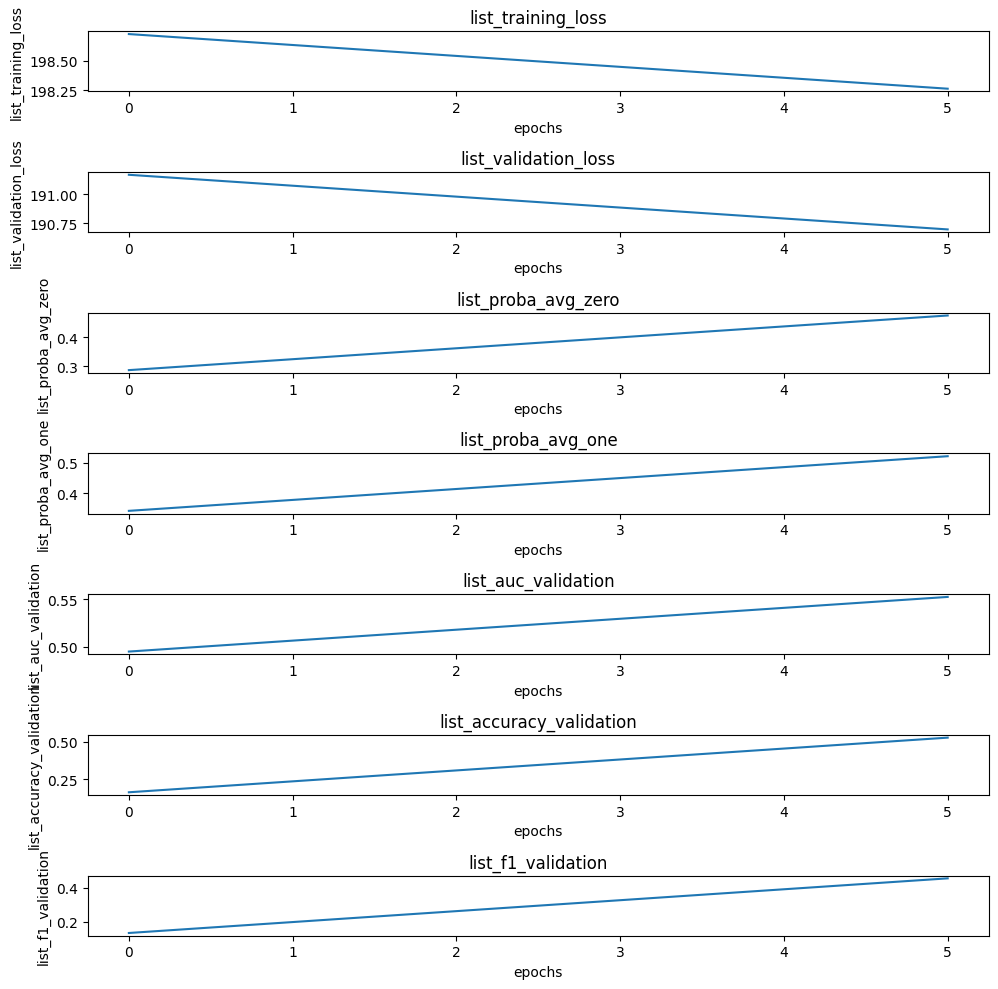

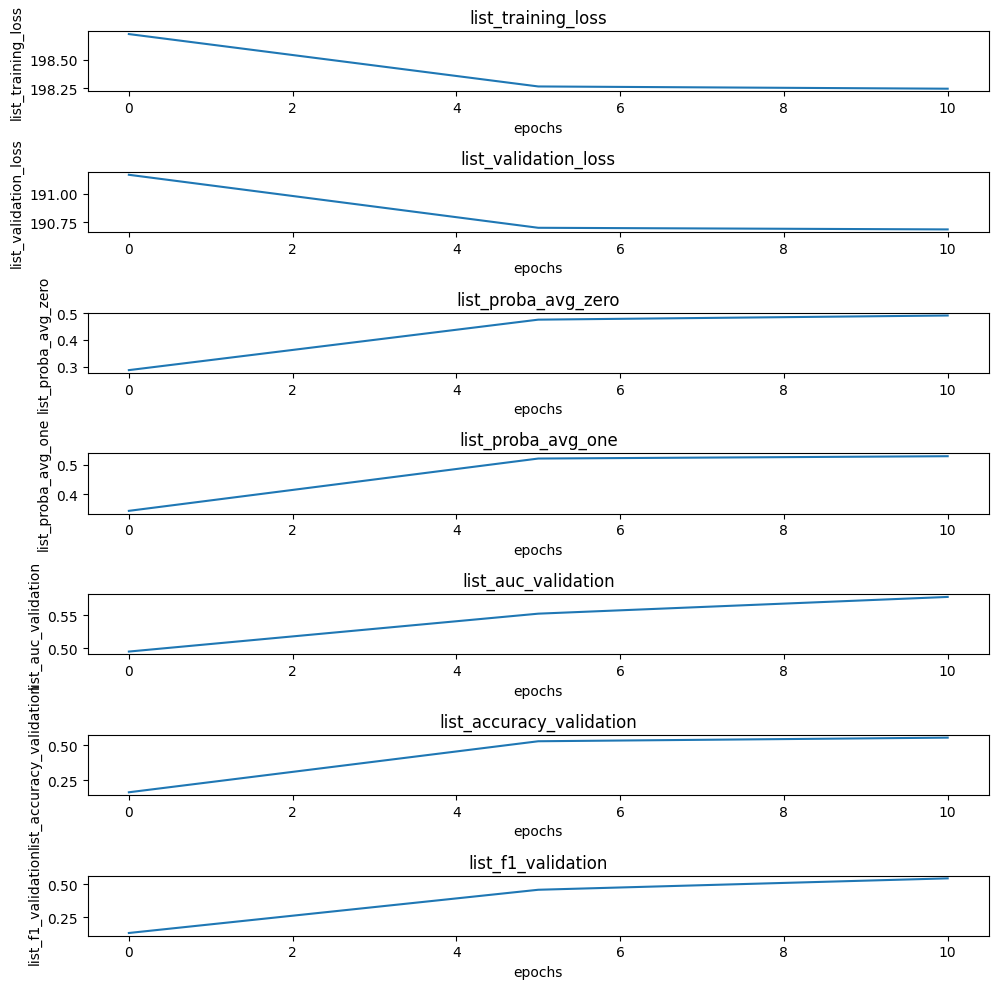

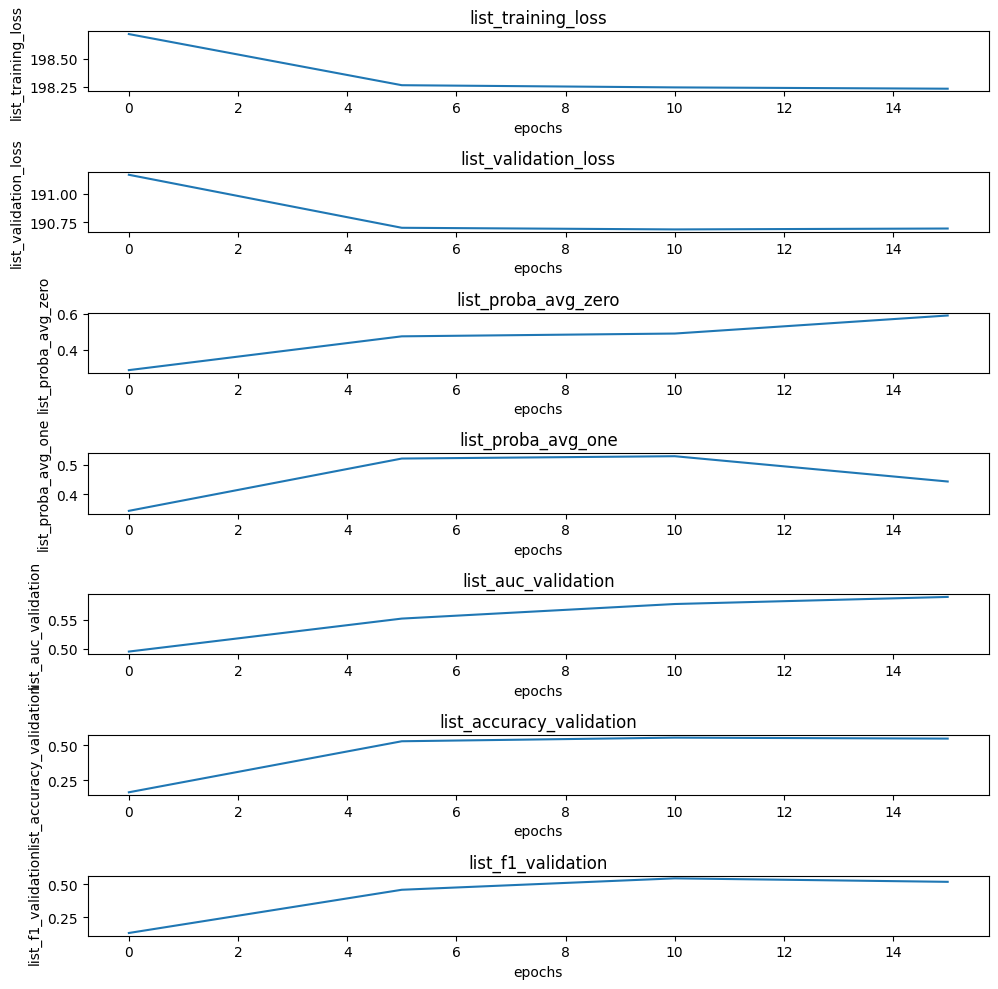

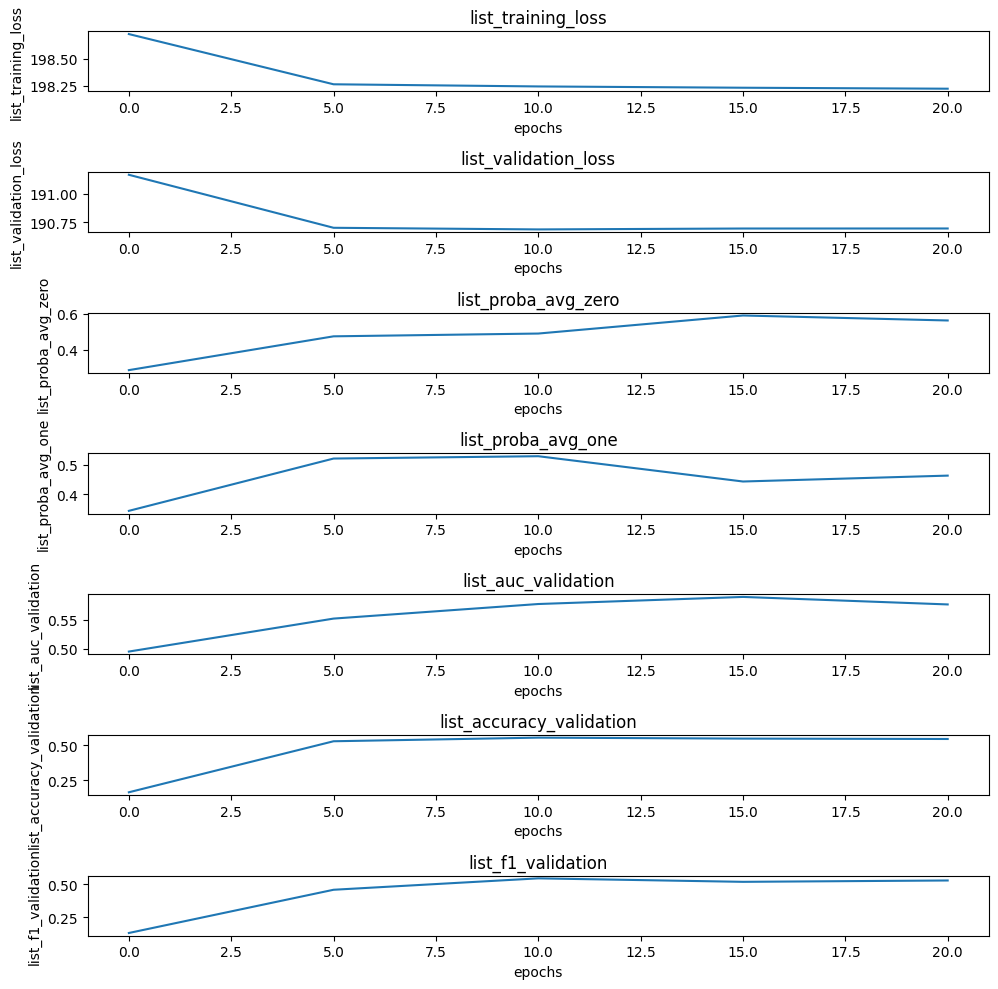

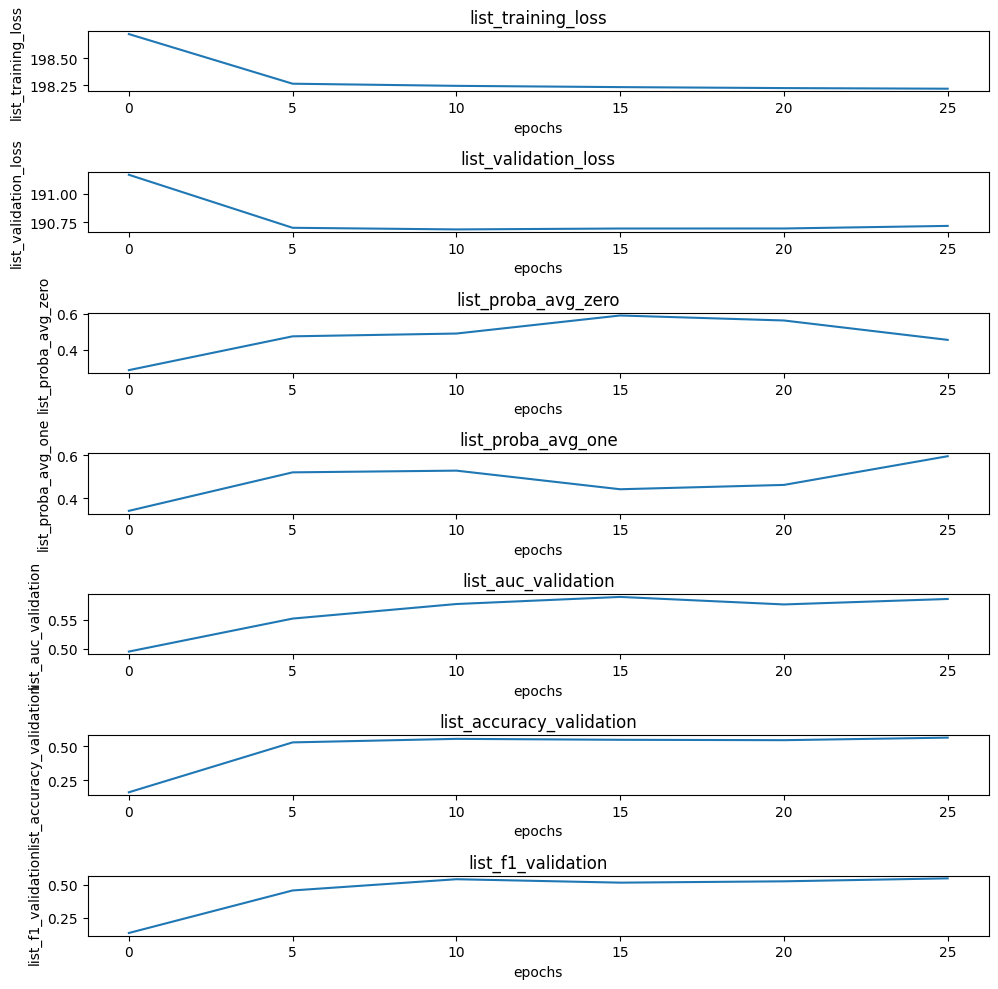

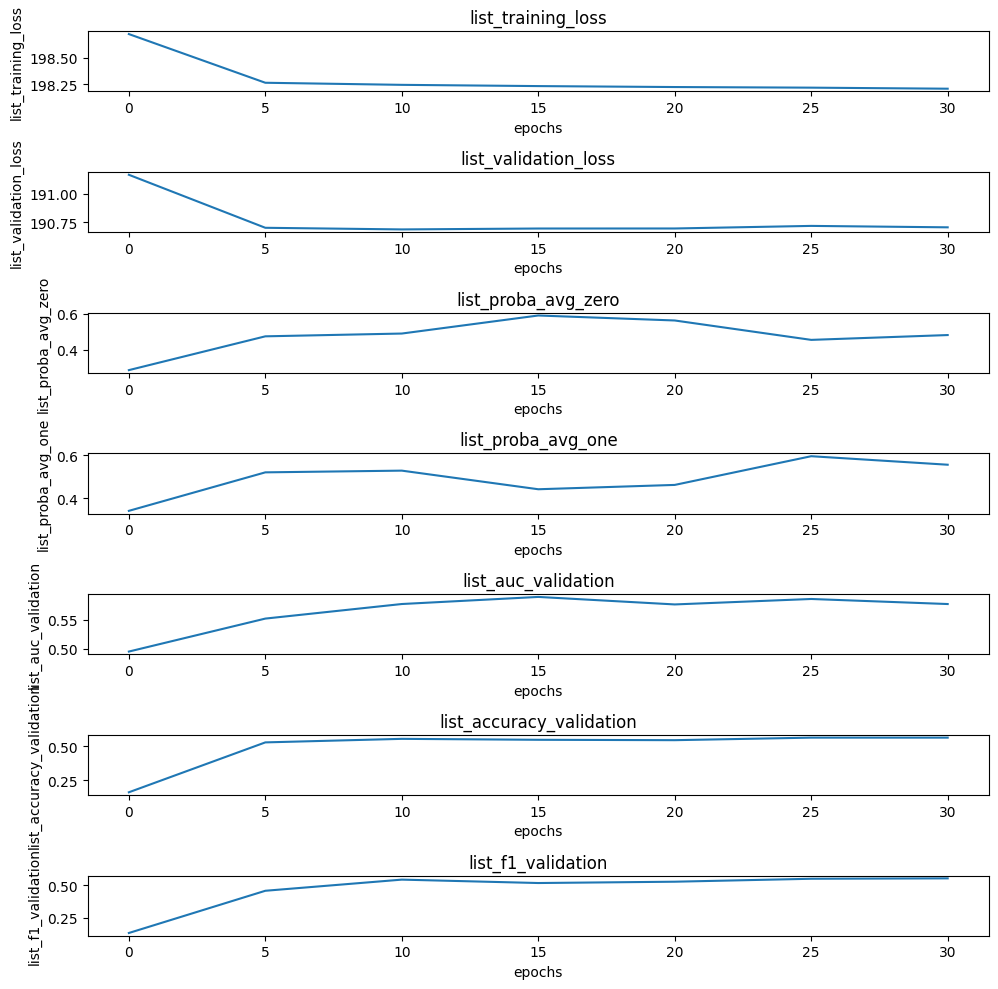

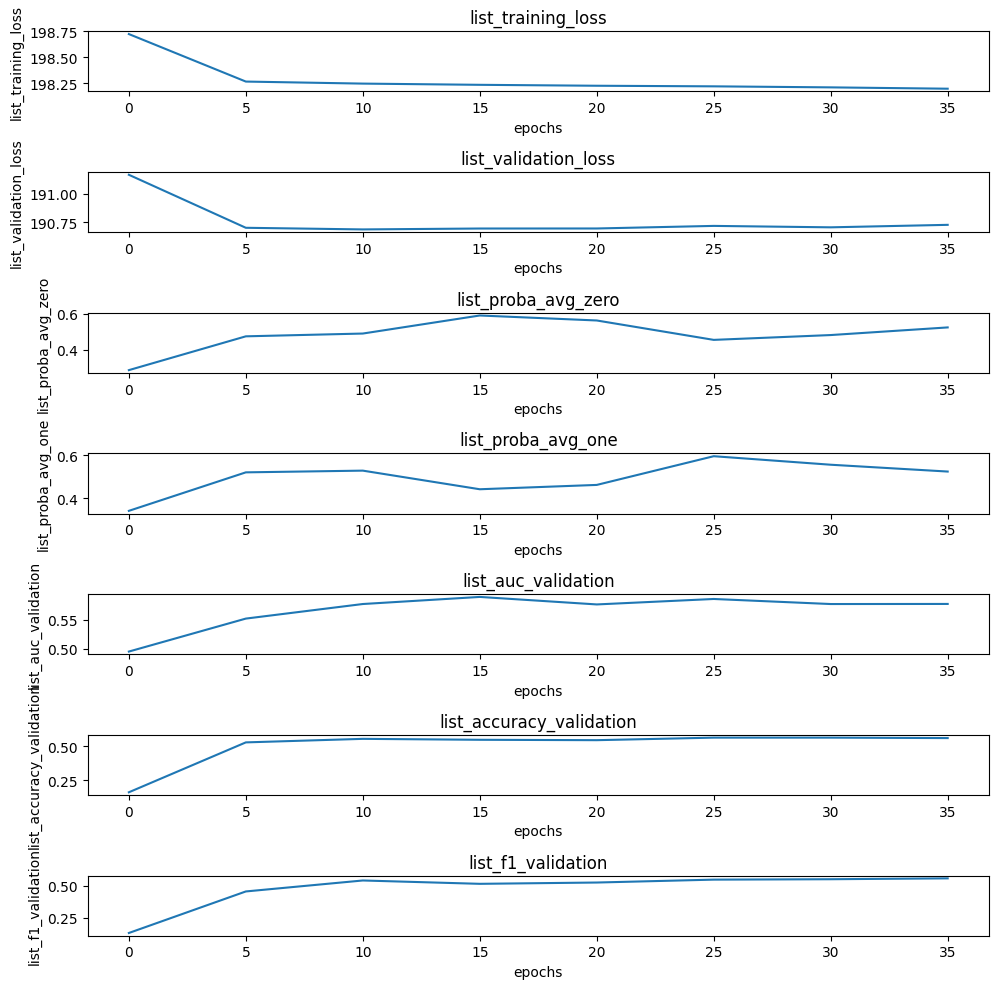

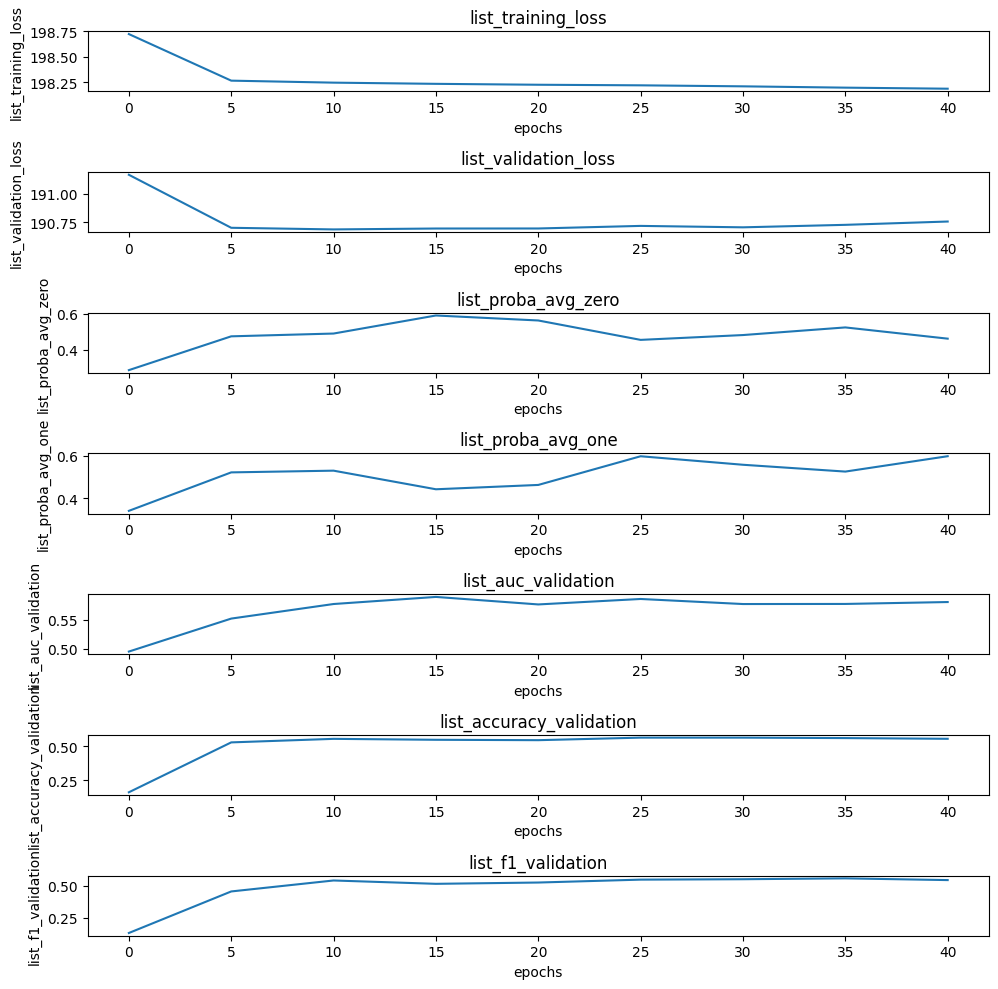

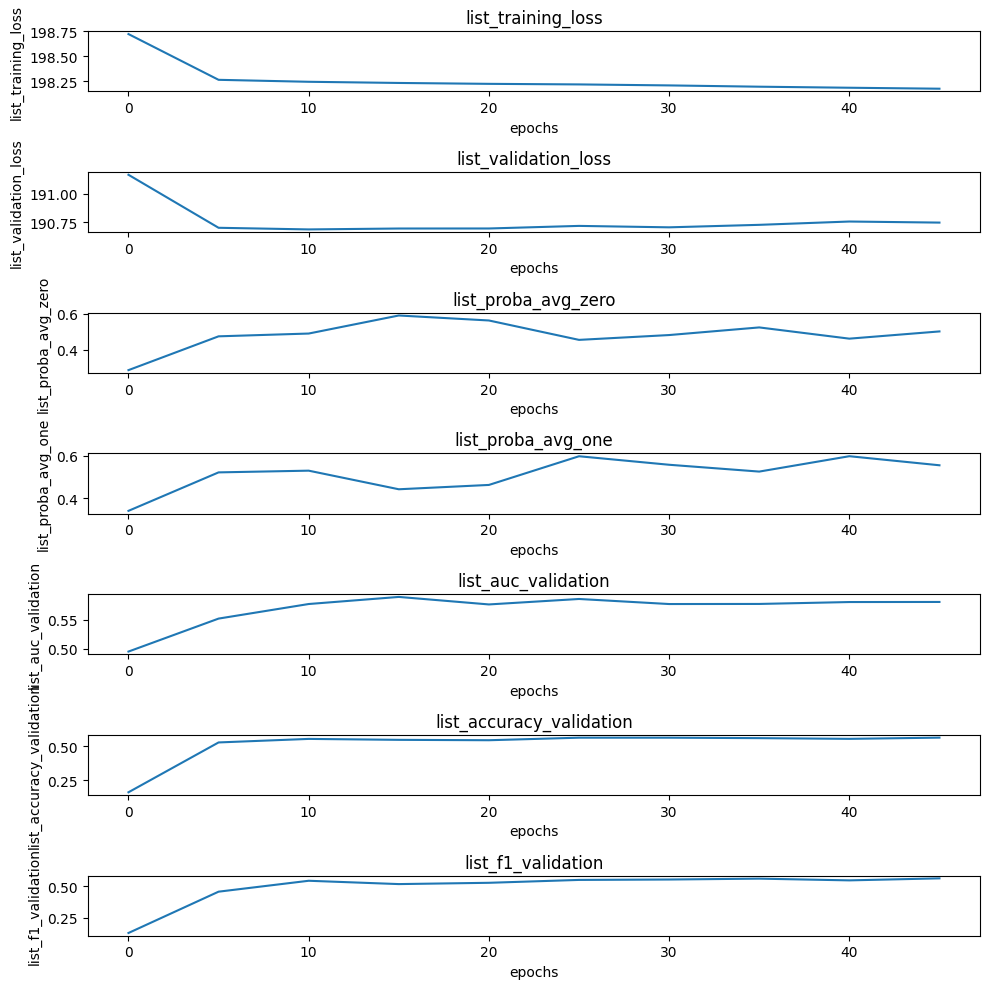

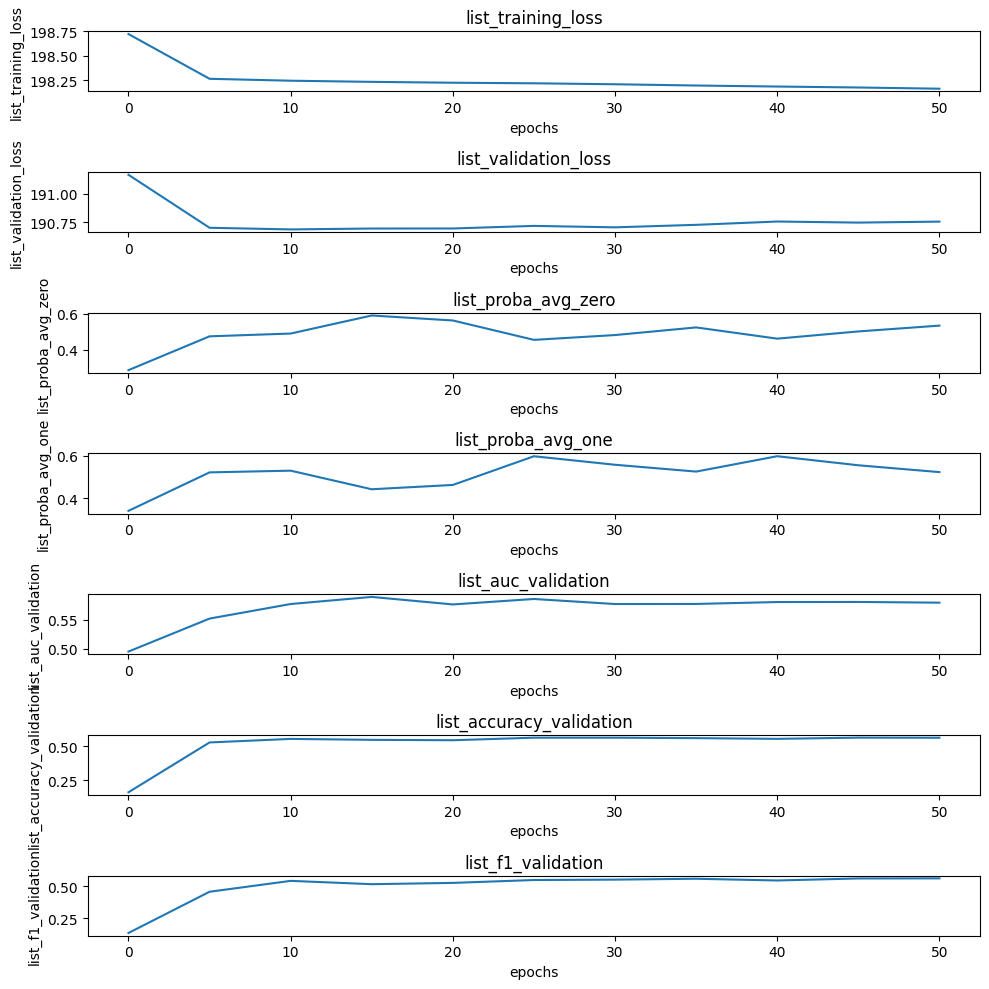

In [5]:
train_model.train_model()

In [6]:
train_model.number_test

253

In [ ]:
test_cat = 'comparaisons'
test_field = 'L1'
test_name = 'L1_Abby'
param_dic = {
    'L1':[True, False]
            }

In [ ]:
testset = TestSet(test_cat=test_cat, test_field=test_field, test_name=test_name, param_dic=param_dic, test_ref=train_model)

In [ ]:
test, list_number_test, list_number_test_to_train = testset.create_tests()

In [ ]:
list_number_test_to_train

In [ ]:
train_model = TrainModel.load_instance_test(233)
train_model.train_model()

In [ ]:
bash_script_train_model = '/gpfs/commons/groups/gursoy_lab/mstoll/codes/launch_tests/launch_bash_script_train_model.sh'
scripts = [ (bash_script_train_model, str(test_instance_number)) for test_instance_number in list_number_test_to_train]

In [ ]:
for bash_script, *number_instance_test in scripts:
    commande = ['bash', bash_script] + number_instance_test
    res = subprocess.run(commande, capture_output=True, text=True)

    print(f"Sortie standard de {bash_script} :", res.stdout)

    # Afficher la sortie d'erreur du script Bash s'il y en a
    if res.stderr:
        print(f"Erreur de {bash_script} :", res.stderr)

    # Vérifier le code de retour du processus
    if res.returncode == 0:
        print(f"{bash_script} s'est exécuté avec succès.")

In [ ]:
instance_test = TrainModel.load_instance_test(141)


In [ ]:
device = 'cuda'
instance_test = instance_test.model.to(device)

In [ ]:
instance_test.device

In [ ]:
instance_test.model.padding_mask_mat

In [ ]:
train_model = TrainTabTransformerModel(model_version=model_version, test_name=test_name, counts_method=counts_method, pheno_method=pheno_method, tryout=tryout, 
                                    CHR=CHR, SNP=SNP, rollup_depth=rollup_depth, binary_classes=binary_classes, padding_token=padding_token, prop_train_test=prop_train_test,
                                    load_data=load_data,save_data=save_data, remove_none=remove_none, compute_features=compute_features, padding=padding, batch_size=batch_size,
                                    data_share=data_share, seuil_diseases=seuil_diseases, equalize_label=equalize_label, embedding_method=embedding_method, 
                                    freeze_embedding=freeze_embedding, Embedding_size=Embedding_size, n_head=n_head, n_layer=n_layer, Head_size=Head_size,
                                    eval_epochs_interval=eval_epochs_interval, eval_batch_interval=eval_batch_interval, p_dropout=p_dropout, masking_padding=masking_padding,
                                    loss_version=loss_version, gamma=gamma, alpha=alpha, total_epochs=total_epochs, learning_rate_max=learning_rate_max, learning_rate_ini=learning_rate_ini,
                                    learning_rate_final=learning_rate_final,warm_up_frac=warm_up_frac, decorelate=decorelate, threshold_corr=threshold_corr, threshold_rare=threshold_rare,
                                    remove_rare=remove_rare, list_env_features=list_env_features, proj_embed=proj_embed, instance_size=instance_size)



In [ ]:
file = '/gpfs/commons/groups/gursoy_lab/mstoll/codes/models/list_models_class/list_instance_tests_saved.csv'
df = pd.read_csv(file)

In [ ]:
df

In [ ]:
df = df.drop('dic_data', axis=1)

In [ ]:
df = df.drop('dic_data_test', axis=1)

In [ ]:
df = df.drop('dic_data_train', axis=1)

In [ ]:
df.to_csv(file)

In [ ]:
train_model.train_model()

In [ ]:
param_dic = {'decorelate':[True,False],
             'threshold-corr':[,],
             'threshold_rare':[,], 
             'remove_rare': ['all','all']
    
}

In [ ]:
param_dic = {'CHR':[],
             'SNP':[]
    
}

In [ ]:
### search for the SNPS 
dir_chrs = f'{path}codes/Data_Files/Training/SNPS'
phewas_cat_file = f'{path}codes/Data_Files/phewas/phewas-catalog.csv'


list_files = os.listdir(dir_chrs)
list_chrs = []
for chr in list_files:
    try:
        list_chrs.append(int(chr))
    except:
        pass

for chr in list_chrs:
    dir_SNPS = f'{dir_chrs}/{str(chr)}'
    list_SNPS = os.listdir(dir_SNPS)
    for SNP in list_SNPS:
        param_dic['CHR'].append(chr)
        param_dic['SNP'].append(SNP)


In [ ]:

test_cat = 'comparaison' # comparaison, assert_model
test_field = 'test_multiple_SNP'
test_name = 'test_multiple_SNP_try1'

In [ ]:
test_set = TestSet(test_cat, test_field, test_name, param_dic, test_ref=train_model)



In [ ]:
test, list_number_test, list_number_test_to_train = test_set.create_tests()

In [ ]:
list_number_test

In [ ]:
bash_script_train_model = '/gpfs/commons/groups/gursoy_lab/mstoll/codes/launch_tests/launch_bash_script_train_model.sh'
scripts = [ (bash_script_train_model, str(test_instance_number)) for test_instance_number in list_number_test_to_train]

In [ ]:
scripts

In [ ]:
for bash_script, *number_instance_test in scripts:
    commande = ['bash', bash_script] + number_instance_test
    res = subprocess.run(commande, capture_output=True, text=True)

    print(f"Sortie standard de {bash_script} :", res.stdout)

    # Afficher la sortie d'erreur du script Bash s'il y en a
    if res.stderr:
        print(f"Erreur de {bash_script} :", res.stderr)

    # Vérifier le code de retour du processus
    if res.returncode == 0:
        print(f"{bash_script} s'est exécuté avec succès.")

In [ ]:
train_model = TrainModel.load_instance_test(36)

In [ ]:
train_model.train_model()

In [ ]:
TrainModel.remove_instance_test(9)

In [ ]:
TestSet.get_analyse_res_test_set(1)

In [ ]:
df_instance_tests_path = '/gpfs/commons/groups/gursoy_lab/mstoll/codes/tests/instance_tests/list_instance_tests_train.csv'
df_instance_tests = pd.read_csv(df_instance_tests_path)

In [ ]:
df_instance_tests

In [ ]:
torch.load('/gpfs/commons/groups/gursoy_lab/mstoll/codes/Data_Files/Embeddings/Abby/embedding_abby_no_1_diseases.pth')

In [ ]:
mask = torch.zeros(4, 5, 6).to(bool)
data = torch.rand(4, 2, 5, 6 )

In [ ]:
mask[0][1] = True

In [ ]:
u = data.transpose(1, -1).transpose(1, 2)

In [ ]:
u[mask]=1

In [ ]:
f = u.transpose(1, 2).transpose(1, -1)

In [ ]:
f[0]

In [ ]:
import torch

# Matrice d'exemple
tensor = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# Condition : éléments supérieurs à 5
condition = tensor > 5

# Filtrer la matrice en fonction de la condition
filtered_tensor = tensor[condition]

print("Matrice originale :\n", tensor)
print("\nÉléments supérieurs à 5 après filtrage :\n", filtered_tensor)


In [ ]:
tensor.shape

In [ ]:
tensor[condition]